In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn

In [2]:
n = 1_000_000
p = 0.5
μ_1, μ_2, μ_3 = 0.2, 0.8, 0.4
σ_1, σ_2, σ_3 = 0.1, 0.05, 0.2

In [3]:
%%time

S = 0.0
for i in range(n):
    X_1 = np.exp(μ_1 + σ_1 * randn())
    X_2 = np.exp(μ_2 + σ_2 * randn())
    X_3 = np.exp(μ_3 + σ_3 * randn())
    S += (X_1 + X_2 + X_3)**p
S / n

CPU times: user 2.64 s, sys: 1.03 ms, total: 2.64 s
Wall time: 2.64 s


2.22969038325803

In [4]:
def compute_mean(n=1_000_000):
    S = 0.0
    for i in range(n):
        X_1 = np.exp(μ_1 + σ_1 * randn())
        X_2 = np.exp(μ_2 + σ_2 * randn())
        X_3 = np.exp(μ_3 + σ_3 * randn())
        S += (X_1 + X_2 + X_3)**p
    return (S / n)

In [5]:
compute_mean()

2.2297463563658777

In [6]:
def compute_mean_vectorized(n=1_000_000):
    X_1 = np.exp(μ_1 + σ_1 * randn(n))
    X_2 = np.exp(μ_2 + σ_2 * randn(n))
    X_3 = np.exp(μ_3 + σ_3 * randn(n))
    S = (X_1 + X_2 + X_3)**p
    return S.mean()

In [7]:
%%time
compute_mean_vectorized()

CPU times: user 64.3 ms, sys: 2.99 ms, total: 67.3 ms
Wall time: 66.9 ms


2.229745373053184

In [8]:
%%time

compute_mean_vectorized()

CPU times: user 64.2 ms, sys: 1 ms, total: 65.3 ms
Wall time: 64.8 ms


2.2298763377333253

In [9]:
%%time

compute_mean_vectorized(n=10_000_000)

CPU times: user 691 ms, sys: 43 ms, total: 734 ms
Wall time: 734 ms


2.2297221888195033

In [10]:
μ = 1.0
σ = 0.1
K = 1
n = 10
β = 0.95

In [11]:
M = 10_000_000

In [12]:
S_n = np.exp(μ + σ * randn(M))
payoffs = np.maximum(S_n - K, 0)
P = β**n * np.mean(payoffs)
P

1.036996814321607

In [13]:
def mc_option_price(M=10_000_000):
    S = np.exp(μ + σ * np.random.randn(M))
    return_draws = np.maximum(S - K, 0)
    P = β**n * np.mean(return_draws) 
    return P

In [14]:
mc_option_price()

1.0370193318483603

In [15]:
μ  = 0.0001
ρ  = 0.1
ν  = 0.001
S0 = 10
h0 = 0

In [16]:
def generate_asset_price(n):
    ## 生成价格路径
    S = np.empty(n)
    h = np.empty(n)
    S[0] = S0
    h[0] = h0
    for t in range(n-1):
        h[t+1] = ρ * h[t] + ν * randn()
        S[t+1] = S[t] * np.exp(μ + np.exp(h[t+1])) * randn()
    return S

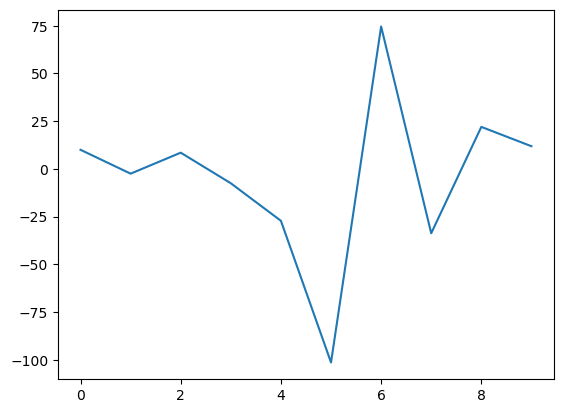

In [17]:
plt.plot(generate_asset_price(n))
plt.show()

In [18]:
def compute_mc_option_price(M=10_000, n=10):
    payoffs = np.empty(M)
    for m in range(M):
        S = generate_asset_price(n)
        payoffs[m] = np.maximum(S[-1] - K, 0)
        
    return β**n * np.mean(payoffs)

In [19]:
%%time
compute_mc_option_price()

CPU times: user 199 ms, sys: 0 ns, total: 199 ms
Wall time: 199 ms


3223.986908938002

In [20]:
def simulate_asset_price_path(μ=μ, S0=S0, h0=h0, n=n, ρ=ρ, ν=ν):
    s = np.empty(n+1)
    s[0] = np.log(S0)

    h = h0
    for t in range(n):
        # 模拟资产价格路径
        s[t+1] = s[t] + μ + np.exp(h) * randn()
        h = ρ * h + ν * randn()

    return np.exp(s)

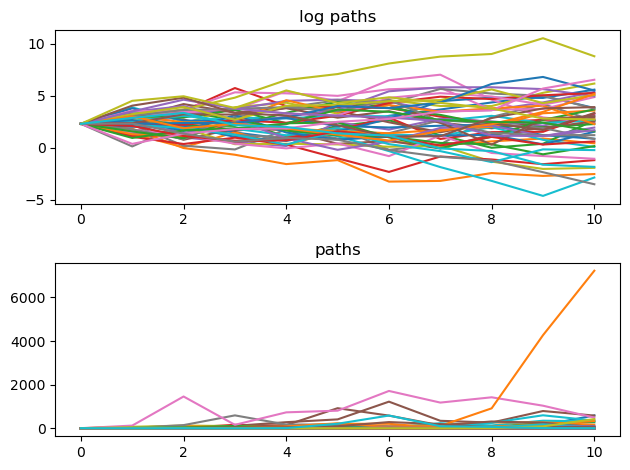

In [21]:
fig, axes = plt.subplots(2, 1)

titles = 'log paths', 'paths'
transforms = np.log, lambda x: x
for ax, transform, title in zip(axes, transforms, titles):
    for i in range(50):
        path = simulate_asset_price_path()
        ax.plot(transform(path))
    ax.set_title(title)

fig.tight_layout()
plt.show()

In [22]:
def compute_call_price(β=β,
                       μ=μ,
                       S0=S0,
                       h0=h0,
                       K=K,
                       n=n,
                       ρ=ρ,
                       ν=ν,
                       M=10_000):
    current_sum = 0.0
    # 对每一个样本路径
    for m in range(M):
        s = np.log(S0)
        h = h0
        # 在时间中模拟
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
        # 并将值 max{S_n - K, 0} 加入 current_sum
        current_sum += np.maximum(np.exp(s) - K, 0)

    return β**n * current_sum / M

In [23]:
%%time
compute_call_price()

CPU times: user 145 ms, sys: 10 µs, total: 145 ms
Wall time: 145 ms


936.1419194639566

In [24]:
def compute_call_price(β=β,
                       μ=μ,
                       S0=S0,
                       h0=h0,
                       K=K,
                       n=n,
                       ρ=ρ,
                       ν=ν,
                       M=10_000):

    s = np.full(M, np.log(S0))
    h = np.full(M, h0)
    for t in range(n):
        Z = np.random.randn(2, M)
        s = s + μ + np.exp(h) * Z[0, :]
        h = ρ * h + ν * Z[1, :]
    expectation = np.mean(np.maximum(np.exp(s) - K, 0))

    return β**n * expectation

In [25]:
%%time
compute_call_price()

CPU times: user 4.78 ms, sys: 17 µs, total: 4.8 ms
Wall time: 4.6 ms


619.9864432088898

In [26]:
%%time
compute_call_price(M=10_000_000)

CPU times: user 4.27 s, sys: 421 ms, total: 4.69 s
Wall time: 4.69 s


904.3961389285662

In [27]:
μ  = 0.0001
ρ  = 0.1
ν  = 0.001
S0 = 10
h0 = 0
K = 100
n = 10
β = 0.95
bp = 120

In [28]:
def compute_call_price_knockout(β=β,
                                μ=μ,
                                S0=S0,
                                h0=h0,
                                K=K,
                                n=n,
                                ρ=ρ,
                                ν=ν,
                                M=10_000,
                                bp=bp):
    current_sum = 0.0
    for m in range(M):
        # 定义价格路径
        s = np.log(S0)
        h = h0
        below_barrier = True
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
            if s >= np.log(bp):
                below_barrier = False
                break
        if below_barrier:
            current_sum += np.maximum(np.exp(s) - K, 0)
    return β**n * current_sum / M

In [29]:
%%time 
compute_call_price_knockout_vectorized(M=1_000_000)

NameError: name 'compute_call_price_knockout_vectorized' is not defined